<a href="https://colab.research.google.com/github/plaban1981/Finetuning/blob/main/Phi_2_Fine_tuning%2C_quantization%2C_and_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U bitsandbytes
!pip install -q -U transformers
!pip install -q -U xformers
!pip install -q -U peft
!pip install -q -U accelerate
!pip install -q -U datasets
!pip install -q -U trl
!pip install -q -U einops
!pip install -q -U nvidia-ml-py3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 93.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

##Load Dataset

In [2]:
from datasets import load_dataset
#
dataset = load_dataset("b-mc2/sql-create-context")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:63: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['answer', 'question', 'context'],
        num_rows: 78577
    })
})

## Format The Dataset

In [3]:
def create_prompt(sample):
  system_prompt_template = """<s>
Below is an instruction that describes a task.Write a response that appropriately completes the request.
### Instruction :<<user_question>>
### Database Schema:
<<database_schema>>
### Response:
<<user_response>>
</s>
"""
  user_message = sample['question']
  user_response = sample['answer']
  database_schema = sample['context']
  prompt_template = system_prompt_template.replace("<<user_question>>",f"{user_message}").replace("<<user_response>>",f"{user_response}").replace("<<database_schema>>",f"{database_schema} ")

  return {"inputs":prompt_template}

In [11]:
instruct_tune_dataset = dataset.map(create_prompt)
instruct_tune_dataset

Map:   0%|          | 0/78577 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['answer', 'question', 'context', 'inputs'],
        num_rows: 78577
    })
})

## Import Required Dependencies
* pyvnml to monitor the VRAM consumption.

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from pynvml import *
from datasets import load_dataset
from trl import SFTTrainer
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
import time, torch

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

## Load the tokenizer and the model with fp16

In [5]:
base_model_id = "microsoft/phi-2"

#Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_id  , use_fast=True)
#Load the model with fp16
model =  AutoModelForCausalLM.from_pretrained(base_model_id, trust_remote_code=True, torch_dtype=torch.float16, device_map={"": 0})
print(print_gpu_utilization())

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/577M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

GPU memory occupied: 6235 MB.
None


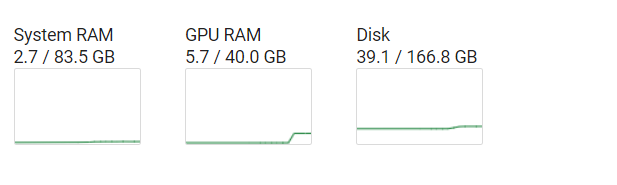

## Model Inference

In [6]:

duration = 0.0
total_length = 0
prompt = []
prompt.append("Write the recipe for a chicken curry with coconut milk.")
prompt.append("Translate into French the following sentence: I love bread and cheese!")
prompt.append("Cite 20 famous people.")
prompt.append("Where is the moon right now?")

for i in range(len(prompt)):
  model_inputs = tokenizer(prompt[i], return_tensors="pt").to("cuda:0")
  start_time = time.time()
  with torch.autocast(model.device.type, dtype=torch.float16, enabled=True):
    output = model.generate(**model_inputs, max_length=500)[0]
  duration += float(time.time() - start_time)
  total_length += len(output)
  tok_sec_prompt = round(len(output)/float(time.time() - start_time),3)
  print("Prompt --- %s tokens/seconds ---" % (tok_sec_prompt))
  print(print_gpu_utilization())
  print(tokenizer.decode(output, skip_special_tokens=True))

tok_sec = round(total_length/duration,3)
print("Average --- %s tokens/seconds ---" % (tok_sec))




Prompt --- 16.869 tokens/seconds ---
GPU memory occupied: 6991 MB.
None
Write the recipe for a chicken curry with coconut milk.
Answer: Ingredients:
- 1 tablespoon of oil
- 1 onion, chopped
- 2 garlic cloves, minced
- 1 teaspoon of ginger, grated
- 1 teaspoon of turmeric
- 1 teaspoon of cumin
- 1 teaspoon of coriander
- 1 teaspoon of garam masala
- 1 teaspoon of paprika
- 1 teaspoon of salt
- 1/4 teaspoon of black pepper
- 1/4 teaspoon of red pepper flakes
- 1/4 cup of chicken broth
- 1 can of coconut milk
- 1 pound of boneless, skinless chicken breasts, cut into bite-sized pieces
- 2 tablespoons of butter
- 2 tablespoons of cornstarch
- 2 tablespoons of water
- 2 tablespoons of chopped cilantro
- Cooked rice, for serving

Directions:
- Heat the oil in a large skillet over medium-high heat. Add the onion, garlic, ginger, turmeric, cumin, coriander, garam masala, paprika, salt, and black pepper. Cook, stirring occasionally, for about 15 minutes, or until the onion is soft and golden.
- 

## Model Finetuning

In [7]:
base_model_id = "microsoft/phi-2"

#Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_eos_token=True, use_fast=True, max_length=250)
tokenizer.padding_side = 'right'
tokenizer.pad_token = tokenizer.eos_token

compute_dtype = getattr(torch, "float16") #change to bfloat16 if are using an Ampere (or more recent) GPU
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=True,
)
model = AutoModelForCausalLM.from_pretrained(
          base_model_id, trust_remote_code=True, quantization_config=bnb_config, revision="refs/pr/23", device_map={"": 0}, torch_dtype="auto", flash_attn=True, flash_rotary=True, fused_dense=True
)
print(print_gpu_utilization())

model = prepare_model_for_kbit_training(model)




Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


modeling_phi.py:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


GPU memory occupied: 8267 MB.
None


## Set LoRA paremters

In [8]:


peft_config = LoraConfig(
        lora_alpha=16,
        lora_dropout=0.05,
        r=16,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules= ["Wqkv", "out_proj"]
)


## set training arguements

In [29]:
training_arguments = TrainingArguments(
        output_dir="./phi2-results2",
        #evaluation_strategy="steps",
        #do_eval=True,
        save_strategy="epoch",
        #save_total_limit=2,
        #eval_steps=100,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=12,
        #per_device_eval_batch_size=1,
        log_level="debug",
        save_steps=100,
        logging_steps=25,
        learning_rate=1e-4,
        eval_steps=50,
        optim='paged_adamw_8bit',
        fp16=True, #change to bf16 if are using an Ampere GPU
        num_train_epochs=1,
        max_steps=1000,
        warmup_steps=100,
        lr_scheduler_type="linear",
        seed=42,

)







PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


*https://huggingface.co/transformers/v4.3.3/_modules/transformers/training_args.html

In [25]:
train_dataset = instruct_tune_dataset.map(batched=True,remove_columns=['answer', 'question', 'context'])
train_dataset

Map:   0%|          | 0/78577 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['inputs'],
        num_rows: 78577
    })
})

In [26]:
train_dataset['train']['inputs'][0]

'<s>\nBelow is an instruction that describes a task.Write a response that appropriately completes the request.\n### Instruction :How many heads of the departments are older than 56 ?\n### Database Schema:\nCREATE TABLE head (age INTEGER) \n### Response:\nSELECT COUNT(*) FROM head WHERE age > 56\n</s>\n'

In [30]:
trainer = SFTTrainer(
        model=model,
        train_dataset=train_dataset["train"],
        #eval_dataset=dataset['test'],
        peft_config=peft_config,
        dataset_text_field="inputs",
        max_seq_length=1024,
        tokenizer=tokenizer,
        args=training_arguments,
        packing=False
)

PyTorch: setting up devices
max_steps is given, it will override any value given in num_train_epochs
Using auto half precision backend


## Start Training

In [31]:
trainer.train()

Currently training with a batch size of: 4
***** Running training *****
  Num examples = 78,577
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 48
  Gradient Accumulation steps = 12
  Total optimization steps = 1,000
  Number of trainable parameters = 7,864,320


Step,Training Loss
25,2.894300
50,2.508600
75,1.471200
100,0.909300
125,0.800700
150,0.778500
175,0.756800
200,0.735400
225,0.711000
250,0.702100


Saving model checkpoint to ./phi2-results2/tmp-checkpoint-1000
tokenizer config file saved in ./phi2-results2/tmp-checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./phi2-results2/tmp-checkpoint-1000/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1000, training_loss=0.7951698360443116, metrics={'train_runtime': 3521.6456, 'train_samples_per_second': 13.63, 'train_steps_per_second': 0.284, 'total_flos': 9.75040447899648e+16, 'train_loss': 0.7951698360443116, 'epoch': 0.61})

## Test inference with the fine-tuned adapter:

In [32]:
base_model_id = "microsoft/phi-2"

#Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_id, use_fast=True)

compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=True,
)
model = AutoModelForCausalLM.from_pretrained(
          base_model_id, trust_remote_code=True, quantization_config=bnb_config, device_map={"": 0}
)
adapter = "/content/phi2-results2/checkpoint-1000"
model = PeftModel.from_pretrained(model, adapter)

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--microsoft--phi-2/snapshots/e35b92df8c544925d84fdab7cc071687bd18a478/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--microsoft--phi-2/snapshots/e35b92df8c544925d84fdab7cc071687bd18a478/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--microsoft--phi-2/snapshots/e35b92df8c544925d84fdab7cc071687bd18a478/tokenizer.json
loading file added_tokens.json from cache at /root/.cache/huggingface/hub/models--microsoft--phi-2/snapshots/e35b92df8c544925d84fdab7cc071687bd18a478/added_tokens.json
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--microsoft--phi-2/snapshots/e35b92df8c544925d84fdab7cc071687bd18a478/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--phi-2/snapshots/e35b92df8c544925d84fdab7cc071687bd18a478/tokenizer_config.json
Specia

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing PhiForCausalLM.

All the weights of PhiForCausalLM were initialized from the model checkpoint at microsoft/phi-2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use PhiForCausalLM for predictions without further training.
loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--phi-2/snapshots/e35b92df8c544925d84fdab7cc071687bd18a478/generation_config.json
Generate config GenerationConfig {}



In [33]:
database_schema= 'CREATE TABLE station (city VARCHAR, lat INTEGER)'
user_question = "List all the cities in a decreasing order of each city's stations' highest latitude."
prompt_template = f""""
Below is an instruction that describes a task.Write a response that appropriately completes the request.
### Instruction :
{user_question}
Database Schema:
{database_schema}
### Response:
"""
prompt_template

'"\nBelow is an instruction that describes a task.Write a response that appropriately completes the request.\n### Instruction :\nList all the cities in a decreasing order of each city\'s stations\' highest latitude.\nDatabase Schema:\nCREATE TABLE station (city VARCHAR, lat INTEGER)\n### Response:\n'

In [35]:
question = "'What are the positions with both players having more than 20 points and less than 10 points and are in Top 10 ranking"
context = "CREATE TABLE player (POSITION VARCHAR, Points INTEGER, Ranking INTEGER)"
#
prompt_template1 = f""""
Below is an instruction that describes a task.Write a response that appropriately completes the request.
### Instruction :
{question}
Database Schema:
{context}
### Response:
"""
prompt_template1

'"\nBelow is an instruction that describes a task.Write a response that appropriately completes the request.\n### Instruction :\n\'What are the positions with both players having more than 20 points and less than 10 points and are in Top 10 ranking\nDatabase Schema:\nCREATE TABLE player (POSITION VARCHAR, Points INTEGER, Ranking INTEGER)\n### Response:\n'

In [36]:
context = '''CREATE TABLE Songs (SongId VARCHAR); CREATE TABLE Band (firstname VARCHAR, id VARCHAR); CREATE TABLE Performance (bandmate VARCHAR)'''
question = "Find the first name of the band mate that has performed in most songs."
#
prompt_template2 = f""""
Below is an instruction that describes a task.Write a response that appropriately completes the request.
### Instruction :
{question}
Database Schema:
{context}
### Response:
"""
prompt_template2

'"\nBelow is an instruction that describes a task.Write a response that appropriately completes the request.\n### Instruction :\nFind the first name of the band mate that has performed in most songs.\nDatabase Schema:\nCREATE TABLE Songs (SongId VARCHAR); CREATE TABLE Band (firstname VARCHAR, id VARCHAR); CREATE TABLE Performance (bandmate VARCHAR)\n### Response:\n'

In [37]:
prompt = []
prompt.append(prompt_template)
prompt.append(prompt_template1)
prompt.append(prompt_template2)
#
for i in range(len(prompt)):
  model_inputs = tokenizer(prompt[i], return_tensors="pt").to("cuda:0")
  start_time = time.time()
  output = model.generate(**model_inputs, max_length=500, no_repeat_ngram_size=10, pad_token_id=tokenizer.eos_token_id, eos_token_id=tokenizer.eos_token_id)[0]
  duration += float(time.time() - start_time)
  total_length += len(output)
  tok_sec_prompt = round(len(output)/float(time.time() - start_time),3)
  print("Prompt --- %s tokens/seconds ---" % (tok_sec_prompt))
  print(print_gpu_utilization())
  print(tokenizer.decode(output, skip_special_tokens=False))

tok_sec = round(total_length/duration,3)
print("Average --- %s tokens/seconds ---" % (tok_sec))

Generate config GenerationConfig {}

Generate config GenerationConfig {}



Prompt --- 12.733 tokens/seconds ---
GPU memory occupied: 6747 MB.
None
"
Below is an instruction that describes a task.Write a response that appropriately completes the request.
### Instruction :
List all the cities in a decreasing order of each city's stations' highest latitude.
Database Schema:
CREATE TABLE station (city VARCHAR, lat INTEGER)
### Response:
SELECT city, MAX(lat) FROM station ORDER BY lat DESC
</p>
</li>
</ol>
</li>
</ol>


</li>
</li>
</ol> 
</li>
</li>
<li>
CREATE TABLE station (city VARCHARP, lat INTEGER)
</li>
</li>
<?php
$sql = "SELECT city, MAX(lat) FROM station"
$result = $sql;
?>
</li>
</ol>  
</li>
</li>
### Database Schema:
CREATE TABLE station (name VARCHAR, lat INTEGER) 
</li>
</li> 
</ol>
</li>
<li> 
CREATE TABLE station (city VARCHARCHAR, lat INTEGER) 


</li>
</ol>
<li>
CREATE TABLE city (name VARCHAR) 
</li>
</ol>
<?php
$sql = "CREATE TABLE city (name VARCHAR)"
$result = $sql;
?</li>
</ol>
</p>
</li>
<li>  
CREATE TABLE station (city VARCHARC, lat INTE

Generate config GenerationConfig {}



Prompt --- 35.818 tokens/seconds ---
GPU memory occupied: 6747 MB.
None
"
Below is an instruction that describes a task.Write a response that appropriately completes the request.
### Instruction :
'What are the positions with both players having more than 20 points and less than 10 points and are in Top 10 ranking
Database Schema:
CREATE TABLE player (POSITION VARCHAR, Points INTEGER, Ranking INTEGER)
### Response:
SELECT POSITION FROM player WHERE Points > 20 AND Points < 10 AND Ranking < 10
</database>
</response>
</database>
</response>
<|endoftext|>
Prompt --- 13.361 tokens/seconds ---
GPU memory occupied: 6747 MB.
None
"
Below is an instruction that describes a task.Write a response that appropriately completes the request.
### Instruction :
Find the first name of the band mate that has performed in most songs.
Database Schema:
CREATE TABLE Songs (SongId VARCHAR); CREATE TABLE Band (firstname VARCHAR, id VARCHAR); CREATE TABLE Performance (bandmate VARCHAR)
### Response:
SELECT fi

#### Response
```
1. SELECT city, MAX(lat) FROM  station ORDER BY lat DESC

2. SELECT POSITION FROM player WHERE Points > 20 AND Points < 10 AND Ranking < 10

3. SELECT firstname FROM Band JOIN Performance ON Band.id = Performance.bandmate JOIN Songs ON Performance.songid = Songs.songid GROUP BY bandmate ORDER BY COUNT(*) LIMIT 1
```

## Save the finetuned model

In [39]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [40]:
!pip install -qU huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.3/330.3 kB 5.3 MB/s eta 0:00:00


In [48]:
from huggingface_hub import notebook_login

notebook_login()

In [49]:
trainer.push_to_hub(commit_message="fine-tuned adapter")

Saving model checkpoint to ./phi2-results2
tokenizer config file saved in ./phi2-results2/tokenizer_config.json
Special tokens file saved in ./phi2-results2/special_tokens_map.json


adapter_model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

events.out.tfevents.1704633677.26119a7fc073.3201.1:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

events.out.tfevents.1704638966.26119a7fc073.3201.2:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

events.out.tfevents.1704633352.26119a7fc073.3201.0:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Plaban81/phi2-results2/commit/42c87737a28ad961d21e16be98e6ba0aa7057b38', commit_message='fine-tuned adapter', commit_description='', oid='42c87737a28ad961d21e16be98e6ba0aa7057b38', pr_url=None, pr_revision=None, pr_num=None)

## Merge the base model

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [58]:
import shutil

shutil.move('/content/phi2-results2', '/content/drive/MyDrive/PHI2')

'/content/drive/MyDrive/PHI2/phi2-results2'

In [59]:
from peft import AutoPeftModelForCausalLM
trained_model = AutoPeftModelForCausalLM.from_pretrained("/content/drive/MyDrive/PHI2/phi2-results2/checkpoint-1000",
                                                         low_cpu_mem_usage=True,
                                                         return_dict=True,
                                                         torch_dtype=torch.float16,
                                                         device_map='auto',)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--phi-2/snapshots/e35b92df8c544925d84fdab7cc071687bd18a478/config.json


The repository for microsoft/phi-2 contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/microsoft/phi-2.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--phi-2/snapshots/e35b92df8c544925d84fdab7cc071687bd18a478/config.json
Model config PhiConfig {
  "_name_or_path": "microsoft/phi-2",
  "activation_function": "gelu_new",
  "architectures": [
    "PhiForCausalLM"
  ],
  "attn_pdrop": 0.0,
  "auto_map": {
    "AutoConfig": "microsoft/phi-2--configuration_phi.PhiConfig",
    "AutoModelForCausalLM": "microsoft/phi-2--modeling_phi.PhiForCausalLM"
  },
  "embd_pdrop": 0.0,
  "flash_attn": false,
  "flash_rotary": false,
  "fused_dense": false,
  "img_processor": null,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "phi-msft",
  "n_embd": 2560,
  "n_head": 32,
  "n_head_kv": null,
  "n_inner": null,
  "n_layer": 32,
  "n_positions": 2048,
  "resid_pdrop": 0.1,
  "rotary_dim": 32,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.36.2",
  "vocab_size": 51200
}

loading weights f

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing PhiForCausalLM.

All the weights of PhiForCausalLM were initialized from the model checkpoint at microsoft/phi-2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use PhiForCausalLM for predictions without further training.
loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--phi-2/snapshots/e35b92df8c544925d84fdab7cc071687bd18a478/generation_config.json
Generate config GenerationConfig {}



In [60]:
lora_merged_model = trained_model.merge_and_unload()

In [61]:
lora_merged_model.save_pretrained("/content/drive/MyDrive/PHI2/phi2-results2/lora_merged_model",safe_serialization=True)

Configuration saved in /content/drive/MyDrive/PHI2/phi2-results2/lora_merged_model/config.json
Configuration saved in /content/drive/MyDrive/PHI2/phi2-results2/lora_merged_model/generation_config.json
The model is bigger than the maximum size per checkpoint (5GB) and is going to be split in 2 checkpoint shards. You can find where each parameters has been saved in the index located at /content/drive/MyDrive/PHI2/phi2-results2/lora_merged_model/model.safetensors.index.json.


In [62]:
tokenizer.save_pretrained("/content/drive/MyDrive/PHI2/phi2-results2/lora_merged_model")

tokenizer config file saved in /content/drive/MyDrive/PHI2/phi2-results2/lora_merged_model/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/PHI2/phi2-results2/lora_merged_model/special_tokens_map.json


('/content/drive/MyDrive/PHI2/phi2-results2/lora_merged_model/tokenizer_config.json',
 '/content/drive/MyDrive/PHI2/phi2-results2/lora_merged_model/special_tokens_map.json',
 '/content/drive/MyDrive/PHI2/phi2-results2/lora_merged_model/vocab.json',
 '/content/drive/MyDrive/PHI2/phi2-results2/lora_merged_model/merges.txt',
 '/content/drive/MyDrive/PHI2/phi2-results2/lora_merged_model/added_tokens.json',
 '/content/drive/MyDrive/PHI2/phi2-results2/lora_merged_model/tokenizer.json')

## Push Model to hub

In [64]:
lora_merged_model.push_to_hub(repo_id="Plaban81/phi2-results2",commit_message="merged model")

Configuration saved in /tmp/tmprk5sw4ql/config.json
Configuration saved in /tmp/tmprk5sw4ql/generation_config.json
The model is bigger than the maximum size per checkpoint (5GB) and is going to be split in 2 checkpoint shards. You can find where each parameters has been saved in the index located at /tmp/tmprk5sw4ql/model.safetensors.index.json.
Uploading the following files to Plaban81/phi2-results2: model-00002-of-00002.safetensors,model-00001-of-00002.safetensors,model.safetensors.index.json,config.json,generation_config.json


model-00002-of-00002.safetensors:   0%|          | 0.00/577M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/Plaban81/phi2-results2/commit/46332d4b8864cebb6c716cb137d94b945bcdfe5d', commit_message='merged model', commit_description='', oid='46332d4b8864cebb6c716cb137d94b945bcdfe5d', pr_url=None, pr_revision=None, pr_num=None)

In [65]:
tokenizer.push_to_hub(repo_id="Plaban81/phi2-results2",commit_message="merged model")

tokenizer config file saved in /tmp/tmp3_7aos4y/tokenizer_config.json
Special tokens file saved in /tmp/tmp3_7aos4y/special_tokens_map.json
Uploading the following files to Plaban81/phi2-results2: merges.txt,added_tokens.json,tokenizer_config.json,vocab.json,special_tokens_map.json,tokenizer.json


CommitInfo(commit_url='https://huggingface.co/Plaban81/phi2-results2/commit/3b3ee95aee8254bde0b43bde1a595d7ca81f2422', commit_message='merged model', commit_description='', oid='3b3ee95aee8254bde0b43bde1a595d7ca81f2422', pr_url=None, pr_revision=None, pr_num=None)

## Perform Inference on Finetuned Model

In [66]:
from peft import LoraConfig,PeftModel,AutoPeftModelForCausalLM
peft_config = LoraConfig(
        lora_alpha=16,
        lora_dropout=0.05,
        r=16,
        bias="none",
        task_type="CAUSAL_LM",
)


## Load the finetuned model

In [67]:
peft_model_id = "Plaban81/phi2-results2"
config = peft_config.from_pretrained(peft_model_id)
#
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path,
                                             return_dict=True,
                                             load_in_4bit=True,
                                             device_map="auto",
                                             )

adapter_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--phi-2/snapshots/e35b92df8c544925d84fdab7cc071687bd18a478/config.json


The repository for microsoft/phi-2 contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/microsoft/phi-2.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--phi-2/snapshots/e35b92df8c544925d84fdab7cc071687bd18a478/config.json
Model config PhiConfig {
  "_name_or_path": "microsoft/phi-2",
  "activation_function": "gelu_new",
  "architectures": [
    "PhiForCausalLM"
  ],
  "attn_pdrop": 0.0,
  "auto_map": {
    "AutoConfig": "microsoft/phi-2--configuration_phi.PhiConfig",
    "AutoModelForCausalLM": "microsoft/phi-2--modeling_phi.PhiForCausalLM"
  },
  "embd_pdrop": 0.0,
  "flash_attn": false,
  "flash_rotary": false,
  "fused_dense": false,
  "img_processor": null,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "phi-msft",
  "n_embd": 2560,
  "n_head": 32,
  "n_head_kv": null,
  "n_inner": null,
  "n_layer": 32,
  "n_positions": 2048,
  "resid_pdrop": 0.1,
  "rotary_dim": 32,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.36.2",
  "vocab_size": 51200
}

Overriding torch_

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing PhiForCausalLM.

All the weights of PhiForCausalLM were initialized from the model checkpoint at microsoft/phi-2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use PhiForCausalLM for predictions without further training.
loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--phi-2/snapshots/e35b92df8c544925d84fdab7cc071687bd18a478/generation_config.json
Generate config GenerationConfig {}



In [68]:
tokenizer= AutoTokenizer.from_pretrained(peft_model_id)

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--Plaban81--phi2-results2/snapshots/3b3ee95aee8254bde0b43bde1a595d7ca81f2422/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--Plaban81--phi2-results2/snapshots/3b3ee95aee8254bde0b43bde1a595d7ca81f2422/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--Plaban81--phi2-results2/snapshots/3b3ee95aee8254bde0b43bde1a595d7ca81f2422/tokenizer.json
loading file added_tokens.json from cache at /root/.cache/huggingface/hub/models--Plaban81--phi2-results2/snapshots/3b3ee95aee8254bde0b43bde1a595d7ca81f2422/added_tokens.json
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--Plaban81--phi2-results2/snapshots/3b3ee95aee8254bde0b43bde1a595d7ca81f2422/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--Plaban81--phi2-results2/snapshots/3b3ee95aee8254bde0b43bde1a5

In [71]:
model = PeftModel.from_pretrained(model,peft_model_id)

adapter_model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

In [73]:
model.get_memory_footprint()

1815953408

In [84]:
model_inputs = tokenizer(prompt_template2, return_tensors="pt").to("cuda:0")
output = model.generate(**model_inputs, max_length=256, no_repeat_ngram_size=10, pad_token_id=tokenizer.eos_token_id, eos_token_id=tokenizer.eos_token_id)[0]

Generate config GenerationConfig {}



In [85]:
output

tensor([    1,   198, 21106,   318,   281, 12064,   326,  8477,   257,  4876,
           13, 16594,   257,  2882,   326, 20431, 32543,   262,  2581,    13,
          198, 21017, 46486,  1058,   198, 16742,   262,   717,  1438,   286,
          262,  4097, 16133,   326,   468,  6157,   287,   749,  7259,    13,
          198, 38105, 10011,  2611,    25,   198, 43387,  6158, 43679, 31772,
          357, 44241,  7390,   569, 31315,  1503,  1776, 29244,  6158, 43679,
        10243,   357, 11085,  3672,   569, 31315,  1503,    11,  4686,   569,
        31315,  1503,  1776, 29244,  6158, 43679, 15193,   357,  3903,  9830,
          569, 31315,  1503,     8,   198, 21017, 18261,    25,   198, 46506,
          717,  3672, 16034, 10243, 32357,  1268, 15193,  6177, 10243,    13,
          312,   796, 15193,    13,  3903,  9830, 32357,  1268, 31772,  6177,
        15193,    13,  3903,  9830,   796, 31772,    13, 34050,   312, 44441,
        11050,   717,  3672, 38678, 11050,   327, 28270,     7, 

## Generate Response

In [93]:
print(tokenizer.decode(output, skip_special_tokens=False)[len(prompt_template2):].split("</response>")[0])

SELECT firstname FROM Band JOIN Performance ON Band.id = Performance.bandmate JOIN Songs ON Performance.bandmate = Songs.songid GROUP BY firstname ORDER BY COUNT(*) DESC LIMIT 1



In [97]:
for i in range(len(prompt)):
  model_inputs = tokenizer(prompt[i], return_tensors="pt").to("cuda:0")
  start_time = time.time()
  output = model.generate(**model_inputs, max_length=500, no_repeat_ngram_size=10, pad_token_id=tokenizer.eos_token_id, eos_token_id=tokenizer.eos_token_id)[0]
  duration += float(time.time() - start_time)
  total_length += len(output)
  tok_sec_prompt = round(len(output)/float(time.time() - start_time),3)
  print("Prompt --- %s tokens/seconds ---" % (tok_sec_prompt))
  print(print_gpu_utilization())
  print(f"RESPONSE:\n {tokenizer.decode(output, skip_special_tokens=False)[len(prompt[i]):].split('</')[0]}")

tok_sec = round(total_length/duration,3)
print("Average --- %s tokens/seconds ---" % (tok_sec))

Generate config GenerationConfig {}

Generate config GenerationConfig {}



Prompt --- 18.803 tokens/seconds ---
GPU memory occupied: 13611 MB.
None
RESPONSE:
 SELECT city FROM station ORDER BY MAX(lat) DESC



Generate config GenerationConfig {}



Prompt --- 17.474 tokens/seconds ---
GPU memory occupied: 13611 MB.
None
RESPONSE:
 SELECT POSITION FROM player WHERE Points > 20 AND Points < 10 AND Ranking < 10

Prompt --- 13.779 tokens/seconds ---
GPU memory occupied: 13611 MB.
None
RESPONSE:
 SELECT firstname FROM Band JOIN Performance ON Band.id = Performance.bandmate JOIN Songs ON Performance.bandmate = Songs.songid GROUP BY firstname ORDER BY COUNT(*) DESC LIMIT 1

Average --- 15.493 tokens/seconds ---
